# Querying and Using SANDAG Covid19 Data from ARCGIS in Python

The San Diego County Health Department has made county-level Covid19 data available on ArcGIS.  See [here](https://sdgis-sandag.opendata.arcgis.com/search?owner=SANDAG_Admin&q=COVID19) for a list of available datasets.  

To create a query link, use the interactive tool on the dataset's API Explorer.  For example, the query string for general county data can be constructed [on this page](https://sdgis-sandag.opendata.arcgis.com/datasets/covid-19-statistics-san-diego-county/geoservice?geometry=-120.229%2C32.968%2C-119.792%2C33.019&orderBy=date&selectedAttribute=newcases).

The examples below demonstrate simple queries of the ArcGIS data and show how to import the data into pandas DataFrames for use in python.  

### Setup
These examples were run in python 3.8.  In addition to python, you will need to install the python packages [requests](https://pypi.org/project/requests/), [numpy](https://pypi.org/project/numpy), and [pandas](https://pypi.org/project/pandas/).

In [23]:
# Import required packages
import pandas as pd
import numpy as np
import requests

import datetime
import sys

print("Python version: {}".format(sys.version))
print("Numpy Version: {}".format(np.__version__))
print("Pandas Version: {}".format(pd.__version__))
print("Requests Version: {}".format(requests.__version__))

# Set default figure size
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

Python version: 3.8.2 (v3.8.2:7b3ab5921f, Feb 24 2020, 17:52:18) 
[Clang 6.0 (clang-600.0.57)]
Numpy Version: 1.18.2
Pandas Version: 1.0.3
Requests Version: 2.23.0


### Preliminaries
The following function is used for all of the queries.  Pass in a well-formed query URL to return a cleaned json string used to instantiate a pandas DataFrame.

In [24]:
def query_database(link):
    ''' Query San Diego County COVID-19 ArcGIS Database
        
        Parameters:
            LINK:  A well formed database query url. 
        
        Returns:
            JSON string with headers and GIS geometry removed
    '''
    f = requests.get(link)
    j = f.json()

    # Clean up the json string
    j.pop('exceededTransferLimit',None)
    [rec.pop('geometry',None) for rec in j['features']]
    
    return j

### Example 1:  Query County-Level Test Results and Rate of New Cases by Date
This example shows how to download data from the [Covid 19 Statistics San Diego County Dataset](https://sdgis-sandag.opendata.arcgis.com/datasets/covid-19-statistics-san-diego-county), which includes the data displayed on the [San Diego County 2019 Coronavirus Disease Local Situation landing page.](https://www.sandiegocounty.gov/content/sdc/hhsa/programs/phs/community_epidemiology/dc/2019-nCoV/status.html)  Use the [API Explorer tab](https://sdgis-sandag.opendata.arcgis.com/datasets/covid-19-statistics-san-diego-county/geoservice?geometry=-120.229%2C32.968%2C-119.792%2C33.019&orderBy=date&selectedAttribute=newcases
) to create the desired query URL string.

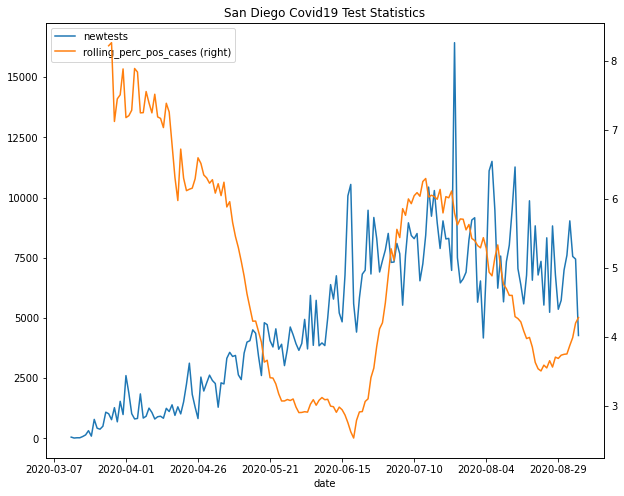

In [25]:
# Perform query
link = 'https://gis-public.sandiegocounty.gov/arcgis/rest/services/Hosted/COVID_19_Statistics_San_Diego_County/FeatureServer/0/query?where=1%3D1&outFields=objectid,date,tests,positives,newtests,rolling_perc_pos_cases,newcases&outSR=4326&f=json'
j = query_database(link)

# Create DataFrame 
df = pd.DataFrame.from_dict([itm['attributes'] for itm in j['features']])

# Translate date values to human readable
df['date']=df['date'].apply(lambda x: datetime.datetime.fromtimestamp(x/1000).strftime('%Y-%m-%d'))

# Reindex
df.index = df['date']
df = df.sort_index()

# Plot
df.loc[:,['newtests','rolling_perc_pos_cases']].plot(secondary_y=['rolling_perc_pos_cases'],title='San Diego Covid19 Test Statistics')

### Example 2:  Query Rate of New Cases by Zip Code by Date
This example shows how to download case incidence by ZIP code from the San Diego Covid-19 Statistics by ZIP Code Dataset. For the query builder, click [here](https://sdgis-sandag.opendata.arcgis.com/datasets/covid-19-statistics-by-zip-code/geoservice).

In [26]:
# Specify start and end dates to limit returned data objects
start_date = "2020-04-15"
end_date = "2020-05-01"

# Perform query
link = "https://gis-public.sandiegocounty.gov/arcgis/rest/services/Hosted/COVID_19_Statistics__by_ZIP_Code/"\
    "FeatureServer/0/query?where=updatedate%20%3E%3D%20TIMESTAMP%20'{start_date}%2000%3A00%3A00'%20"\
    "AND%20updatedate%20%3C%3D%20TIMESTAMP%20'{end_date}%2000%3A00%3A00'&outFields=ziptext,zipcode_zip,case_count,"\
    "updatedate&outSR=4326&f=json".format(start_date=start_date,end_date=end_date)    
j = query_database(link)

# Create DataFrame 
df = pd.DataFrame.from_dict([itm['attributes'] for itm in j['features']])

# Translate date values to human readable
df['updatedate']=df['updatedate'].apply(lambda x: datetime.datetime.fromtimestamp(x/1000).strftime('%Y-%m-%d'))

# Reindex
df.index = df['updatedate']
df = df.sort_index().drop(columns='updatedate')

# If 'ziptext' is NaN, copy value from 'zipcode_zip' field.
df.loc[df.ziptext.isnull(),'ziptext'] = df.loc[df.ziptext.isnull(),'ziptext'].apply(lambda x: str(x))

# Pivot table to create ZIP code columns
# Note when pivoting use more generalized `pd.pivot_table` instead of `pd.DataFrame.pivot` 
# so that duplicate entries (i.e. same updatedate, zipcode) can be dealt with by taking the max value
df=pd.pivot_table(df,index = df.index, columns='ziptext',values='case_count', aggfunc = np.max)
df

ziptext,91901,91902,91905,91906,91910,91911,91913,91914,91915,91916,...,92130,92131,92134,92136,92139,92140,92145,92154,92161,92173
updatedate,,,,,,,,,,,,,,,,,,,,,
2020-04-15,2.0,17.0,1.0,1.0,66.0,80.0,39.0,14.0,25.0,1.0,...,25.0,10.0,NaN,3.0,33.0,11.0,NaN,86.0,2.0,39.0
2020-04-16,2.0,18.0,1.0,NaN,66.0,83.0,40.0,14.0,27.0,1.0,...,26.0,10.0,NaN,3.0,34.0,12.0,NaN,92.0,1.0,43.0
2020-04-17,2.0,18.0,1.0,NaN,68.0,88.0,41.0,14.0,27.0,1.0,...,27.0,10.0,NaN,3.0,35.0,13.0,3.0,95.0,1.0,47.0
2020-04-18,2.0,18.0,1.0,NaN,68.0,94.0,43.0,14.0,30.0,1.0,...,27.0,10.0,NaN,3.0,37.0,13.0,3.0,102.0,1.0,52.0
2020-04-19,2.0,18.0,2.0,NaN,70.0,98.0,43.0,14.0,31.0,1.0,...,27.0,10.0,NaN,3.0,39.0,13.0,3.0,107.0,1.0,59.0
2020-04-20,3.0,22.0,2.0,NaN,73.0,106.0,47.0,14.0,31.0,1.0,...,29.0,10.0,NaN,3.0,42.0,13.0,3.0,132.0,1.0,66.0
2020-04-21,3.0,23.0,2.0,NaN,75.0,108.0,52.0,14.0,34.0,1.0,...,29.0,10.0,NaN,4.0,41.0,13.0,3.0,137.0,NaN,69.0
2020-04-22,3.0,23.0,2.0,NaN,87.0,115.0,57.0,15.0,34.0,1.0,...,29.0,10.0,NaN,4.0,43.0,13.0,3.0,173.0,NaN,74.0
2020-04-23,4.0,23.0,2.0,NaN,100.0,129.0,60.0,15.0,39.0,1.0,...,30.0,10.0,NaN,4.0,47.0,14.0,3.0,212.0,NaN,81.0


### Example 3: Query Cases by Episode Date
San Diego County's Covid 19 Triggers Dashboard requires calculation of the 7-day average case rate measured using episode date with 7-day lag as described in [this pdf document.](https://www.sandiegocounty.gov/content/dam/sdc/hhsa/programs/phs/Epidemiology/Triggers_for_Modifying_HOO.pdf)  The data to calculate the 7-day lag is found in the [Covid 19 Cases by Episode Date dataset](https://sdgis-sandag.opendata.arcgis.com/datasets/covid19-cases-by-episode-date/geoservice?selectedAttribute=case_count_excluding_inmates).  This example shows how to download the data from that dataset and for each episode date, select only the datum with the latest update date.

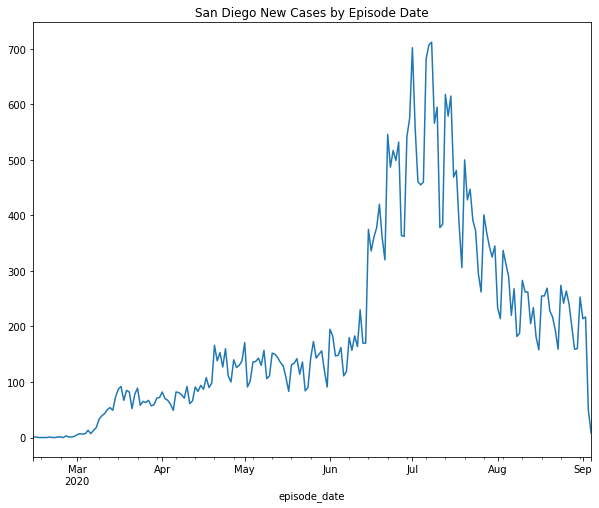

In [27]:
link = 'https://gis-public.sandiegocounty.gov/arcgis/rest/services/Hosted/COVID19_Cases_by_Episode_Date/FeatureServer/0/query?where=1%3D1&outFields=episode_date,update_date,case_count_excluding_inmates&outSR=4326&f=json'
    
j = query_database(link)

# Create DataFrame
df = pd.DataFrame.from_dict([itm['attributes'] for itm in j['features']])

# Drop NaN Values
df = df.dropna(subset=['case_count_excluding_inmates'])

# Translate date values to human readable
df['update_date']=pd.to_datetime(df['update_date'].apply(lambda x: datetime.datetime.fromtimestamp(x/1000).strftime('%Y-%m-%d')))
df['episode_date']=pd.to_datetime(df['episode_date'].apply(lambda x: datetime.datetime.fromtimestamp(x/1000).strftime('%Y-%m-%d')))

# For each episode_date, keep only the datum with the latest update_date
df = df.groupby('episode_date').apply(lambda x: x.sort_values(by='update_date').iloc[-1,:])

# Reindex
df.index=df['episode_date']
df = df.drop(columns=['episode_date'])
df = df.sort_index()

# Plot
df['case_count_excluding_inmates'].plot(title='San Diego New Cases by Episode Date')